In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')


In [2]:
# Read in the netcdf file for SMB

ds = nc.Dataset('IRH_Data/Derwael_SMB_Combined_IceEquiv.nc')
#smb_old = np.array(ds.variables['smb'][:], dtype=type(ds.variables))
smb_before_adjustment = np.array(ds.variables['smb'][:])
X = np.array(ds.variables['x'][:])
Y = np.array(ds.variables['y'][:])
smb_before_adjustment.shape, len(X), len(Y)
smb_before_adjustment = smb_before_adjustment.T
smb_before_adjustment.shape, len(X), len(Y)

((178, 159), 178, 159)

In [3]:
# Read in the csv file with dsdt

data = pd.read_csv('../Simulations/CurrentTests/n4E5_0/n4E5dsdtTime50.csv', sep=",")


In [4]:
# Interpolate dsdt data onto a meshgrid the same shape as the netcdf file

grid_x, grid_y = np.mgrid[min(X):max(X):178j, min(Y):max(Y):159j]

#grid_x, grid_y = np.mgrid[min(Y):max(Y):159j, min(X):max(X):178j]

dsdt = scipy.interpolate.griddata((data["Points:0"], data["Points:1"]), data["dsdt"], (grid_x, grid_y), method='linear')
dsdt

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_9945/2223753126.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ticks=[-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])


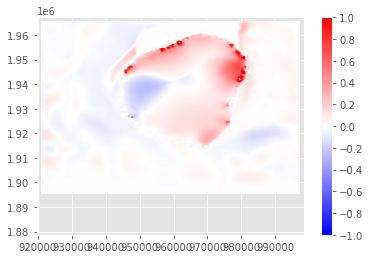

In [5]:
# Plot the dsdt field

fig, ax = plt.subplots(1, 1)
CS = ax.contourf(grid_x, grid_y, dsdt, levels=np.linspace(-1.0,1.0,500), cmap='bwr')
fig.colorbar(CS, ticks=[-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])



/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_9945/894008132.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ticks=[-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])


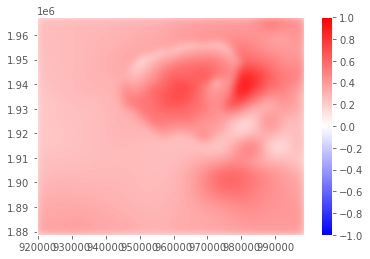

In [6]:
# Plot the previous smb field

fig, ax = plt.subplots(1, 1)
CS = ax.contourf(grid_x, grid_y, smb_before_adjustment, levels=np.linspace(-1.0,1.0,500), cmap='bwr')
fig.colorbar(CS, ticks=[-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])



In [7]:
# Read in the data that gives a polygon for the grounding line

dfGL = pd.read_csv("../Data/GroundingLine.csv")

points = np.column_stack((list(dfGL["Points:0"])[::10], list(dfGL["Points:1"])[::10]))

# [list(dfGL["Points:0"]), list(dfGL["Points:1"])]
alpha = 0.95 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

poly = Polygon(zip(list(hull_pts[0]), list(hull_pts[1])))

for i in range(len(X)):
    for j in range(len(Y)):
        boolean = poly.contains(Point(X[i], Y[j]))
        if boolean == False:
            dsdt[i][j] = "nan" # This needs to be changed for the appropriate data





/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_9945/123773657.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ticks=[-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])


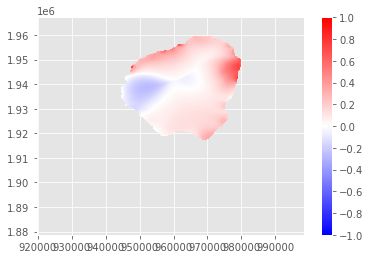

In [8]:
# Plot the dsdt field after elimination of ice shelf

fig, ax = plt.subplots(1, 1)
CS = ax.contourf(grid_x, grid_y, dsdt, levels=np.linspace(-1.0,1.0,500), cmap='bwr')
fig.colorbar(CS, ticks=[-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])


In [9]:
# Make the dsdt adjustment

smb_after_adjustment = smb_before_adjustment - dsdt

for i in range(len(smb_after_adjustment)):
    for j in range(len(smb_after_adjustment[0])):
        if smb_after_adjustment[i][j] < 0:
            smb_after_adjustment[i][j] = 0.0

# Make sure ice shelf has old SMB values
            
smb_after_adjustment[np.isnan(smb_after_adjustment)] = smb_before_adjustment[np.isnan(smb_after_adjustment)]



In [10]:
len(smb_after_adjustment)

178

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_9945/2199614426.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ticks=[-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])


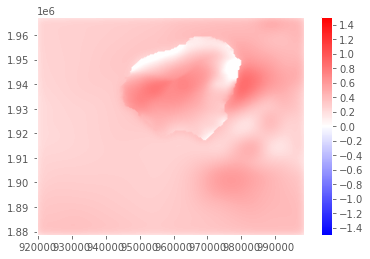

In [11]:
# Plot the new smb field

fig, ax = plt.subplots(1, 1)
CS = ax.contourf(grid_x, grid_y, smb_after_adjustment, levels=np.linspace(-1.5,1.5,500), cmap='bwr')
fig.colorbar(CS, ticks=[-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])



In [25]:
# Apply a Gaussian filter to smooth the transition

sigma_x = 1.0
sigma_y = 1.0

sigma = [sigma_x, sigma_y]
smoothed = sp.ndimage.gaussian_filter(smb_after_adjustment, sigma, mode='constant')


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_9945/4058162394.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ticks=[-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])


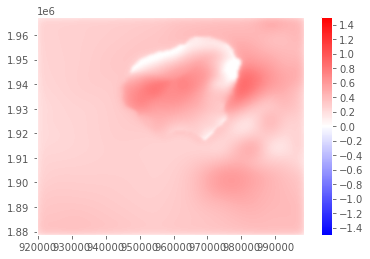

In [26]:
# Plot the new smoothed smb field

fig, ax = plt.subplots(1, 1)
CS = ax.contourf(grid_x, grid_y, smoothed, levels=np.linspace(-1.5,1.5,500), cmap='bwr')
fig.colorbar(CS, ticks=[-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])



In [27]:
# Read out new SMB data as a netcdf file

smoothed = smoothed.T
smoothed = xr.DataArray(
    data=smoothed,
    dims=['y', 'x'],
    coords=dict(
        x=X,
        y=Y
    )
)

smoothed.to_netcdf('SMB_dsdt_adjustment_n4E5Time50.nc')
smoothed.close()

